# Lab  1 - A frequentist example

##### Keywords: frequentist statistics,  installing python,  exponential distribution, poisson distribution, maximum likelihood,  bootstrap

## Contents
{:.no_toc}
* 
{: toc}

## Learning Aims

- using scipy.stats
- MLE
- bootstrap
- pandas
- matplotlib histogram considerations

$\newcommand{\Ex}{\mathbb{E}}$
$\newcommand{\Var}{\mathrm{Var}}$
$\newcommand{\Cov}{\mathrm{Cov}}$
$\newcommand{\SampleAvg}{\frac{1}{N({S})} \sum_{s \in {S}}}$
$\newcommand{\indic}{\mathbb{1}}$
$\newcommand{\avg}{\overline}$
$\newcommand{\est}{\hat}$
$\newcommand{\trueval}[1]{#1^{*}}$
$\newcommand{\Gam}[1]{\mathrm{Gamma}#1}$

## Installing Python

We shall be using Python 3.5 in this course.

### Installation

Download Anaconda from here:
https://www.continuum.io/downloads

There are two ways to do this. You could choose to install either the 3.5 version or the 2.7 version.

If you chose to install the 3.5 version you are done. 

### The 2.7 version

If you chose to install the 2.7 version you have some work to do.

Create a conda environment for python 3.5 with anaconda:

`conda create -n py35 python=3.5 anaconda`

Update it

`conda update -n py35 anaconda`

This will pull down all the 3.5 stuff.

### Running in a conda environment

If you now want to run your shiny new python 3.5 environment, you should "activate it"

`source activate py35`

(or, if you have anaconda on a non-standard place and not in your path like i do

`source /anaconda/envs/py35/bin/activate py35`

)

You ought to read more about the conda command. See http://conda.pydata.org/docs/_downloads/conda-cheatsheet.pdf (critical) and https://jakevdp.github.io/blog/2016/08/25/conda-myths-and-misconceptions/ (to understand the difference between conda and pip and why python has both (we'll use both in this course).

You ought to now `conda install seaborn` or `pip install seaborn`.

In [44]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline
# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

## Data on the birth of babies

>Forty-four babies -- a new record -- were born in one 24-hour period at
the Mater Mothers' Hospital in Brisbane, Queensland, Australia, on
December 18, 1997.  For each of the 44 babies, _The Sunday Mail_
recorded the time of birth, the sex of the child, and the birth weight
in grams. Also included is the number of minutes since midnight for
each birth.

REFERENCE:
Steele, S. (December 21, 1997), "Babies by the Dozen for Christmas:
24-Hour Baby Boom," _The Sunday Mail_ (Brisbane), p. 7.

"Datasets
and Stories" article "A Simple Dataset for Demonstrating Common
Distributions" in the _Journal of Statistics Education_ (Dunn 1999).

Columns

       1 -  8  Time of birth recorded on the 24-hour clock
       9 - 16  Sex of the child (1 = girl, 2 = boy)
      17 - 24  Birth weight in grams
      25 - 32  Number of minutes after midnight of each birth

In [45]:
df = pd.read_table("data/babyboom.dat.txt", header=None, sep='\s+', 
                   names=['24hrtime','sex','weight','minutes'])
df.head()

,24hrtime,sex,weight,minutes
0,5,1,3837,5
1,104,1,3334,64
2,118,2,3554,78
3,155,2,3838,115
4,257,2,3625,177


Bin the number of births into hourly bins

In [46]:
df['minsbin'] = df.minutes // 60
df.head()

,24hrtime,sex,weight,minutes,minsbin
0,5,1,3837,5,0
1,104,1,3334,64,1
2,118,2,3554,78,1
3,155,2,3838,115,1
4,257,2,3625,177,2


### Samples vs population

But we have never aked ourselves the philosophical question: what is data? **Frequentist statistics** is one answer to this philosophical question. It treats data as a **sample** from an existing **population**.

This notion is probably clearest to you from elections, where some companies like Zogby or CNN take polls. The sample in these polls maybe a 1000 people, but they "represent" the electoral population at large. We attempt to draw inferences about how the population will vote based on these samples.

## Choosing a model: the exponential distribution

Let us characterize our particular sample statistically then, using a *probability distribution*

The exponential distribution occurs naturally when describing the lengths of the inter-arrival times in a homogeneous Poisson process.

It takes the form:
$$
f(x;\lambda) = \begin{cases}
\lambda e^{-\lambda x} & x \ge 0, \\
0 & x < 0.
\end{cases}
$$

From Wikipedia: *In probability theory, a Poisson process is a stochastic process which counts the number of events and the time that these events occur in a given time interval. The time between each pair of consecutive events has an exponential distribution with parameter $\lambda$ and each of these inter-arrival times is assumed to be independent of other inter-arrival times. The process is named after the French mathematician Siméon Denis Poisson and is a good model of radioactive decay, telephone calls and requests for a particular document on a web server, among many other phenomena.*

In our example above, we have the arrival times of the babies. There is no reason to expect any specific clustering in time, so one could think of modelling the arrival of the babies via a poisson process.

Furthermore, the Poisson distribution can be used to model the number of births each hour over the 24-hour period.

### What does the exponential distribution look like?

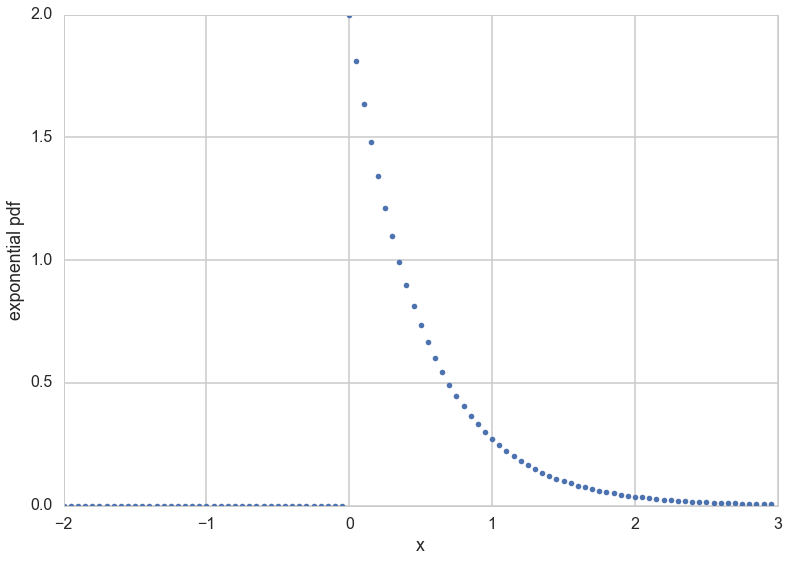

In [47]:
f = lambda x, l: l*np.exp(-l*x)*(x>0)
xpts=np.arange(-2,3,0.05)
plt.plot(xpts,f(xpts, 2),'.');
plt.xlabel("x")
plt.ylabel("exponential pdf")

Note: **some of the code, and ALL of the visual style for the distribution plots below was shamelessly stolen from https://gist.github.com/mattions/6113437/ **.

//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


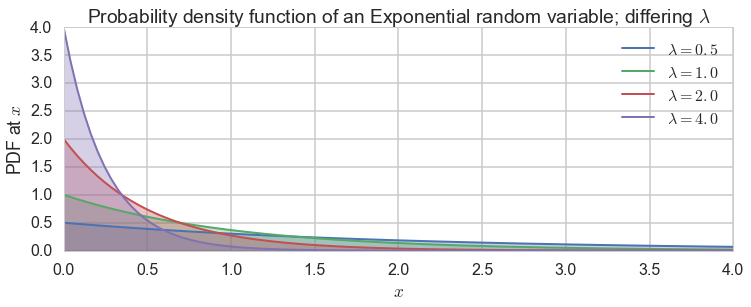

In [48]:
from scipy.stats import expon

x = np.linspace(0,4, 100)
colors=sns.color_palette()

lambda_ = [0.5, 1, 2, 4]
plt.figure(figsize=(12,4))
for l,c in zip(lambda_,colors):
    plt.plot(x, expon.pdf(x, scale=1./l), lw=2, 
                color=c, label = "$\lambda = %.1f$"%l)
    plt.fill_between(x, expon.pdf(x, scale=1./l), color=c, alpha = .33)
    
plt.legend()
plt.ylabel("PDF at $x$")
plt.xlabel("$x$")
plt.title("Probability density function of an Exponential random variable;\
 differing $\lambda$");

### How would we draw from this distribution?

Lets use the built in machinery in `scipy.stats`:

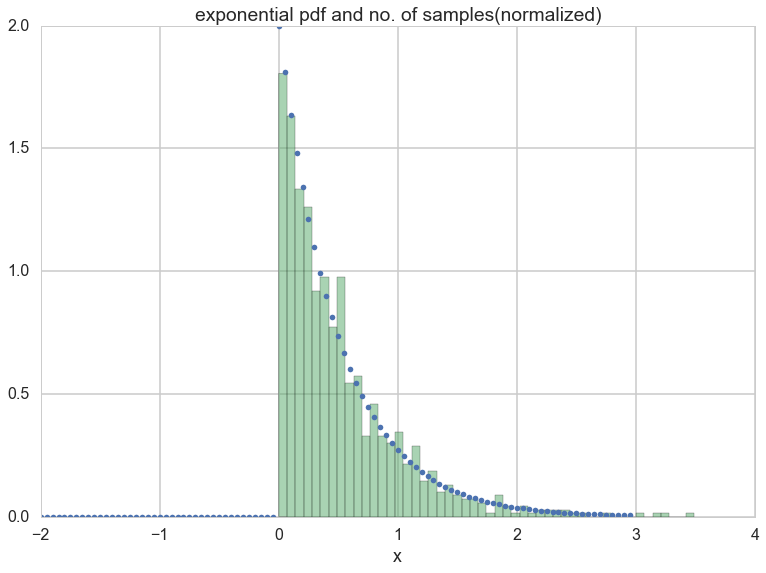

In [49]:
from scipy.stats import expon
plt.plot(xpts,expon.pdf(xpts, scale=1./2.),'.')
plt.hist(expon.rvs(size=1000, scale=1./2.), normed=True, alpha=0.5, bins=50);
#if you remove normed=True you will get the actual number of samples
plt.xlabel("x")
plt.title("exponential pdf and no. of samples(normalized)");

In `scipy.stats`, you can alternatively create a frozen object, which holds values of things like the scale

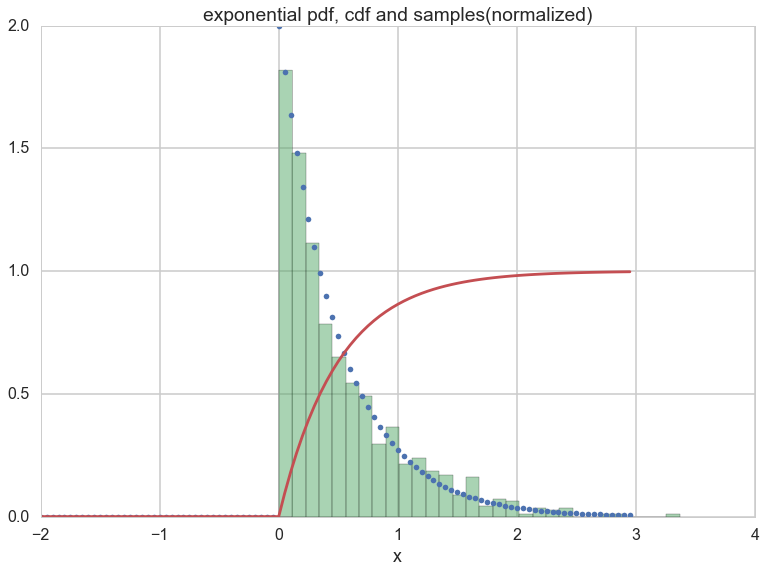

In [50]:
rv = expon(scale=0.5)
plt.plot(xpts,rv.pdf(xpts),'.')
plt.hist(rv.rvs(size=1000), normed=True, alpha=0.5, bins=30);
plt.plot(xpts, rv.cdf(xpts));
plt.xlabel("x")
plt.title("exponential pdf, cdf and samples(normalized)");

## The Poisson distribution

The Poisson distribution is another discrete distribution, it expresses the probability of a given number of events occurring in a fixed interval of time (or space, volume, etc.). One assumption made is that these events occur with a known average rate and independently of each other. An example is the number of electrons detected by a sensor in an electron microscope during a time interval, or the number of soldiers in the Prussian army killed accidentally by horse kicks [(see here)](http://en.wikipedia.org/wiki/Poisson_distribution).

The Poisson distribution is defined as:


$$ f(k; \mu)= \frac{\mu^k e^{-\mu}}{k!}, $$

where $k$ is the number of events, $\mu$ is a positive real number, and $e$ is Euler's number ($e = 2.71828 \ldots$).

//anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


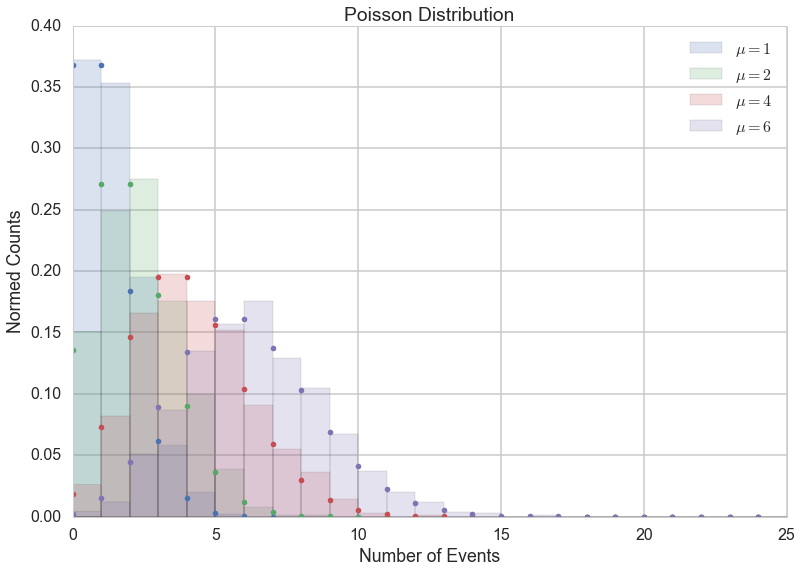

In [42]:
from scipy.stats import poisson
# generate samples for different values of mu
kpts=np.arange(0,25)
for mu, c in zip([1,2, 4, 6], sns.color_palette()[:4]):
    randomVariates = poisson.rvs(mu, size=1000)
    plt.hist(randomVariates, normed=True, color=c, alpha=0.2, bins=range(0,26), label='$\mu=' + np.str(mu) + '$')
    plt.plot(kpts, poisson.pmf(kpts, mu), '.', color=c)

plt.legend()
plt.title("Poisson Distribution")
plt.xlabel("Number of Events")
plt.ylabel("Normed Counts");

### Understanding our data using a  histogram-plotted distribution

Lets play with our data a bit to understand it:

The first birth occurred at 0005, and the last birth in the 24-hour period at 2355. Thus the 43 inter-birth times happened over a 1430-minute period, giving a theoretical mean of 1430/43 = 33.26 minutes between births.

Lets plot a histogram of the inter-birth times

33.25581395348837


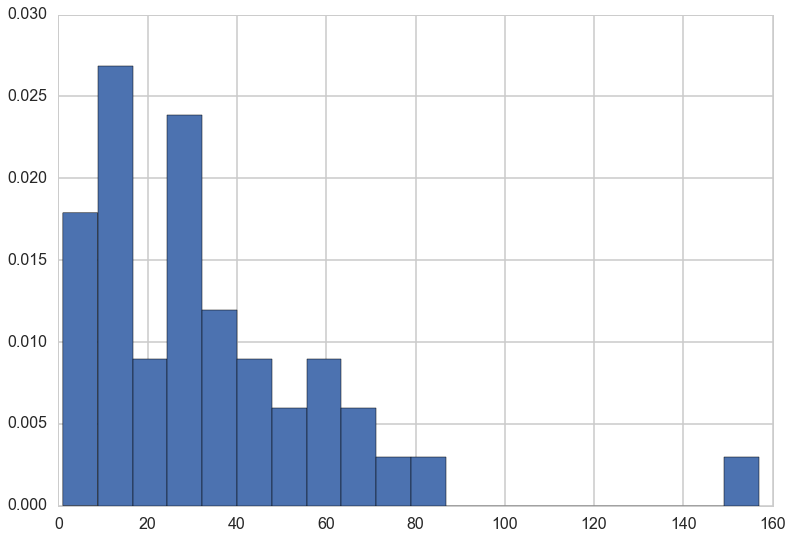

In [93]:
timediffs = df.minutes.diff()[1:]
print(timediffs.mean())
timediffs.hist(bins=20, normed=True);

And do the same for the poisson

In [52]:
poiskcount = df.groupby('minsbin')['minutes'].count()
poiskcount

minsbin
0     1
1     3
2     1
4     4
7     2
8     2
9     1
10    3
11    1
12    2
13    1
14    4
15    1
16    2
17    1
18    3
19    4
20    3
21    2
22    1
23    2
Name: minutes, dtype: int64

The exponential distribution is a continuous distribution and has a pdf.  The default  `normed=True` option for histograms in matplotlib aims to give us a normalized density by setting the area of the histogram to 1. We can play with the number of bins: this is a bit of an art. Too few and you under-represent variability/ Too many and you overfit to it. Play to see what works for you. I will sometimes use `sns.kdeplot` and  try and adjust bins to match.

In this course you will be binning samples very often, so its important to get a feel for this.

Since the Poisson is a discrete distribution, it has a probability mass function. Normalizing a pdf is not what we want here, rather, the values of the pmf (which are probabilities) should sum to 1. So we take matters into our own hands.

We make sure that every point has equal mass, so that the total mass is one. Then the mass at any point depends on how many samples  (the count) we have for it.

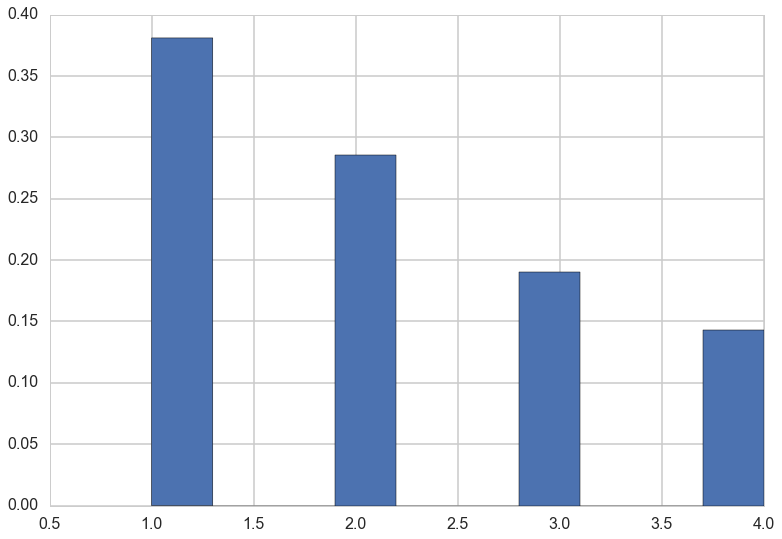

In [94]:
weights = np.ones_like(poiskcount)/len(poiskcount)
poiskcount.hist(weights=weights)

In [75]:
weights

(array([ 0.04761905,  0.04761905,  0.04761905,  0.04761905,  0.04761905,
         0.04761905,  0.04761905,  0.04761905,  0.04761905,  0.04761905,
         0.04761905,  0.04761905,  0.04761905,  0.04761905,  0.04761905,
         0.04761905,  0.04761905,  0.04761905,  0.04761905,  0.04761905,
         0.04761905]), 21)

### Maximum Likelihood Estimation


One of the techniques used to estimate such parameters in frequentist statistics is **maximum likelihood estimation**. Briefly, the idea behind it is:

The product 

$$
L(\lambda) = \prod_{i=1}^n P(x_i \mid \lambda)
$$

gives us a measure of how likely it is to observe values $x_1,...,x_n$ given the parameters $\lambda$. Maximum likelihood fitting consists of choosing the appropriate "likelihood" function $L=P(X \mid \lambda)$ to maximize for a given set of observations. How likely are the observations if the model is true?

Often it is easier and numerically more stable to maximise the log likelyhood:

$$
\ell(\lambda) = \sum_{i=1}^n ln(P(x_i \mid \lambda))
$$

In the case of the exponential distribution we have:

$$
\ell(lambda) = \sum_{i=1}^n ln(\lambda e^{-\lambda x_i}) = \sum_{i=1}^n \left( ln(\lambda) - \lambda x_i \right).
$$

Maximizing this:

$$
\frac{d \ell}{d\lambda} = \frac{n}{\lambda} - \sum_{i=1}^n x_i = 0
$$

and thus:

$$
\frac{1}{\est{\lambda_{MLE}}} = \frac{1}{n}\sum_{i=1}^n x_i,
$$

which is identical to the simple estimator we used above. Usually one is not so lucky and one must use numerical optimization techniques.


This makes intuitive sense: if you get babies at an average rate of 2 per hour, then you can expect to wait half an hour on average for every baby.

In [54]:
lambda_from_mean = 1./timediffs.mean()
print(lambda_from_mean, 1./lambda_from_mean)

0.03006993006993007 33.25581395348837


//anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


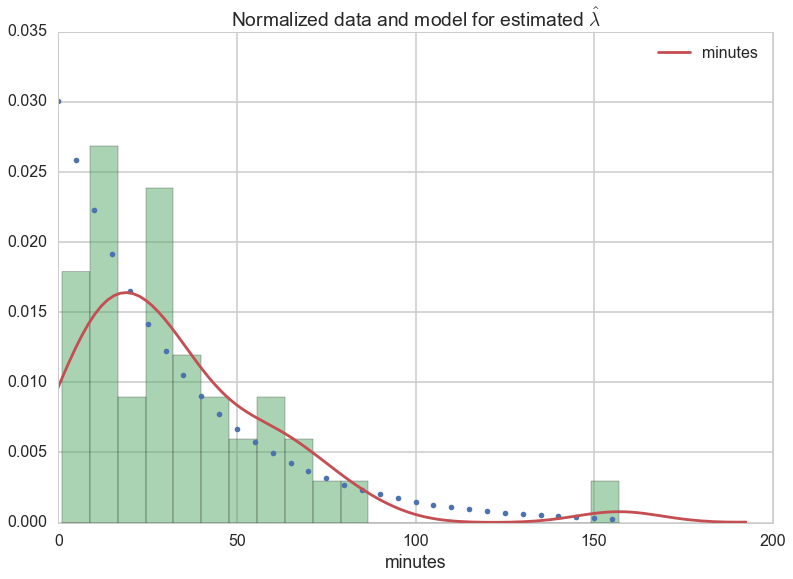

In [95]:
minutes=np.arange(0, 160, 5)
rv = expon(scale=1./lambda_from_mean)
plt.plot(minutes,rv.pdf(minutes),'.')
timediffs.hist(normed=True, alpha=0.5, bins=20);
sns.kdeplot(timediffs)
plt.xlabel("minutes");
plt.xlim([0,200])
plt.title("Normalized data and model for estimated $\hat{\lambda}$");

What did we just do? We made a 'point estimate' of the scale or rate parameter as a compression of our data. 

### For Poisson

In the case of the poisson distribution we have:

$$
\ell(lambda) = \sum_{i=1}^n \left( k_i ln(\mu) - \mu - ln(k_i!) \right).
$$

You maximize this now.

*your answer here* 

Maximizing this:

$$
\frac{d \ell}{d\mu} = \frac{1}{\mu}\sum_{i=1}^n k_i - n = 0
$$

and thus:

$$
\est{\mu_{MLE}} = \frac{1}{n}\sum_{i=1}^n k_i
$$

or just the sample mean!

In [32]:
mumle = np.mean(poiskcount)
mumle

2.0952380952380953

In [38]:
np.std(poiskcount)#note mean != stdev, not a great poisson

1.0647942749999

Make a similar plot to the exponential for the poisson, with a histogram, a kde, and the pmf.

//anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


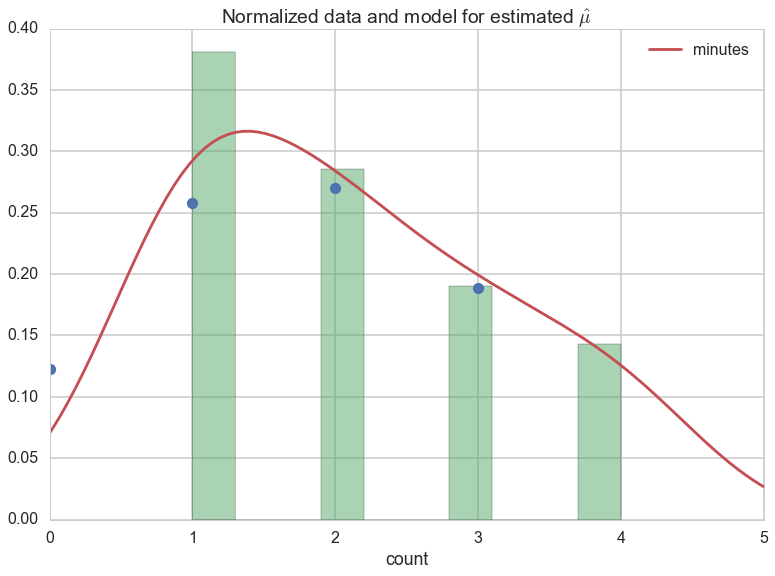

In [77]:
#your code here
counts=np.arange(0, 4, 1)
poisrv = poisson(mumle)
plt.plot(counts,poisrv.pmf(counts),'o')
poiskcount.hist(weights=weights, alpha=0.5);
sns.kdeplot(poiskcount)
plt.xlabel("count");
plt.xlim([0,5])
plt.title("Normalized data and model for estimated $\hat{\mu}$");

## FREQUENTIST STATISTICS 

In frequentist statistics, the data we have in hand, is viewed as a **sample** from a population. So if we want to estimate some parameter of the population, like say the mean, we estimate it on the sample.

This is because we've been given only one sample. Ideally we'd want to see the population, but we have no such luck.

The parameter estimate is computed by applying an estimator $F$ to some data $D$, so $\est{\lambda} = F(D)$. 


**The parameter is viewed as fixed and the data as random, which is the exact opposite of the Bayesian approach which you will learn later in this class. **

For the babies, lets assume that an exponential distribution is a good description of the baby arrival process. Then we consider some larger population of babies from which this sample is drawn, there is some true $\trueval{\lambda}$ which defines it. We dont know this. The best we can do to start with is to estimate  a lambda from the data set we have, which we denote $\est{\lambda}$. 

Now, imagine that I let you peek at the entire population in this way: I gave you some M data sets **drawn** from the population, and you can now find the mean on each such dataset, of which the one we have here is one.
So, we'd have M means. You can think of these means as coming from some fixed parameter by some data drawing process

Thus if we had many replications of this data set: that is, data from other days, an **ensemble** of data sets, for example, we can compute other $\est{\lambda}$, and begin to construct the **sampling distribution** of $\lambda$.

But we dont.



### Sampling Distribution of the rate

So, in the babies case, the uncertainty in the parameter estimate can be measured by computing the **sampling distribution** of the estimator. 
What you are doing is sampling many Data Sets $D_i$ from the true population (which we are not given you will argue, and you are right, but just wait a bit), say M of them, each of size N, from some true model $p(\cdot|\trueval{\lambda})$. We will now calculate M $\est{\lambda}_i$, one for each dataset. As we let $M \rightarrow \infty$, the distribution induced on $\est{\lambda}$ is the sampling distribution of the estimator.

We can use the sampling distribution to put confidence intervals on the estimation of the parameters. 

### Bootstrap

Bootstrap tries to approximate our sampling distribution. If we knew the true parameters of the population, we could generate M fake datasets. Then we could compute the parameter (or another estimator) on each one of these, to get a empirical sampling distribution of the parameter or estimator, and which will give us an idea of how typical our sample is, and thus, how good our parameter estimations from our sample are.
(again from murphy)

But we dont have the true parameter. So we generate these samples, using the parameter we calculated. Or, alteratively, we sample with replacement the X from our original sample D, generating many fake datasets, and then compute the distribution on the parameters as before. 

We do it here for the mean of the time differences. We could also do it for its inverse, $\lambda$.

### Non Parametric

Resample the data! We can then plot the distribution of the mean time-difference in each sample.

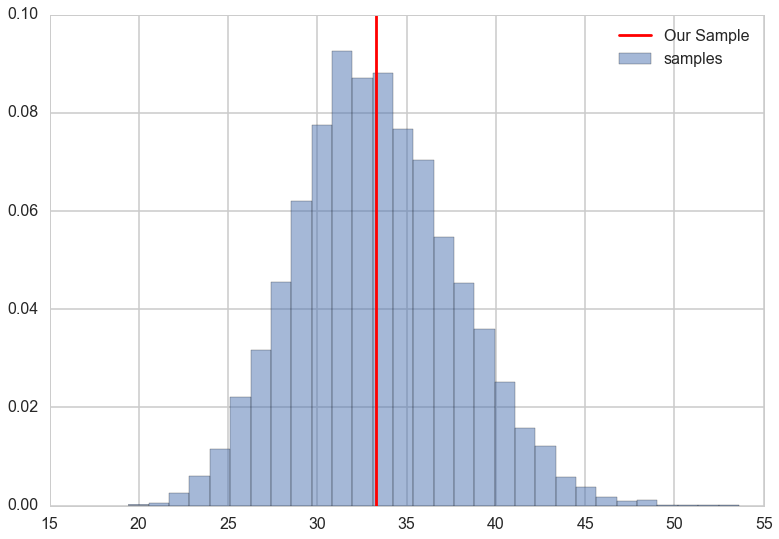

In [83]:
M_samples=10000
N_points = timediffs.shape[0]
bs_np = np.random.choice(timediffs, size=(M_samples, N_points), replace=True)
sd_mean=np.mean(bs_np, axis=1)
sd_std=np.std(bs_np, axis=1)
plt.hist(sd_mean, bins=30, normed=True, alpha=0.5,label="samples");
plt.axvline(timediffs.mean(), 0, 1, color='r', label='Our Sample')
plt.legend()

The above procedure os resampling directly into a 2d array might seem a bit strange, so we repeat the same process split up logically into M replications of size N samples below and ,ake the same plot.

In [84]:
M_samples=10000
N_points = timediffs.shape[0]
bs_np = np.ones(shape=(M_samples, N_points))
bs_np[0,:].shape

(43,)

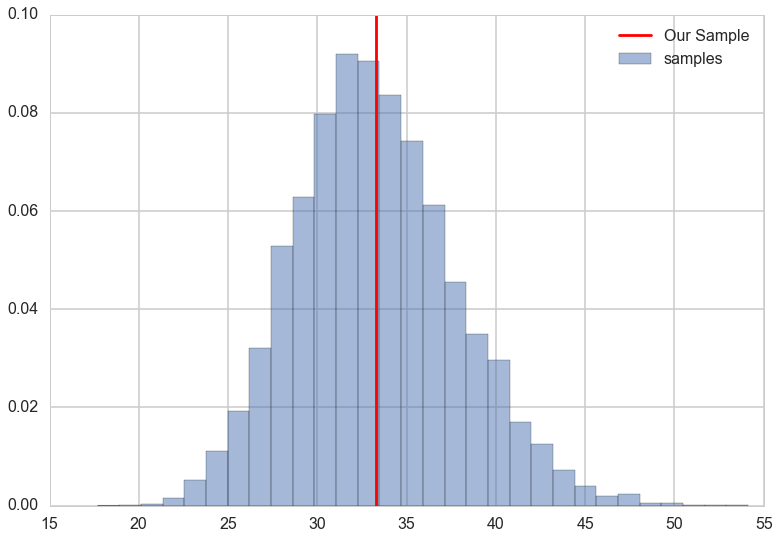

In [85]:
for i in range(M_samples):
    bs_np[i,:] = np.random.choice(timediffs, size=N_points, replace=True)
sd_mean=np.mean(bs_np, axis=1)
sd_std=np.std(bs_np, axis=1)
plt.hist(sd_mean, bins=30, normed=True, alpha=0.5,label="samples");
plt.axvline(timediffs.mean(), 0, 1, color='r', label='Our Sample')
plt.legend()

### Parametric 

And here we do it in a parametric way. We get an "estimate" of the parameter from our sample, and them use the exponential distribution to generate many datasets, and then fir the parameter on each one of those datasets. We can then plot the distribution of the mean time-difference.

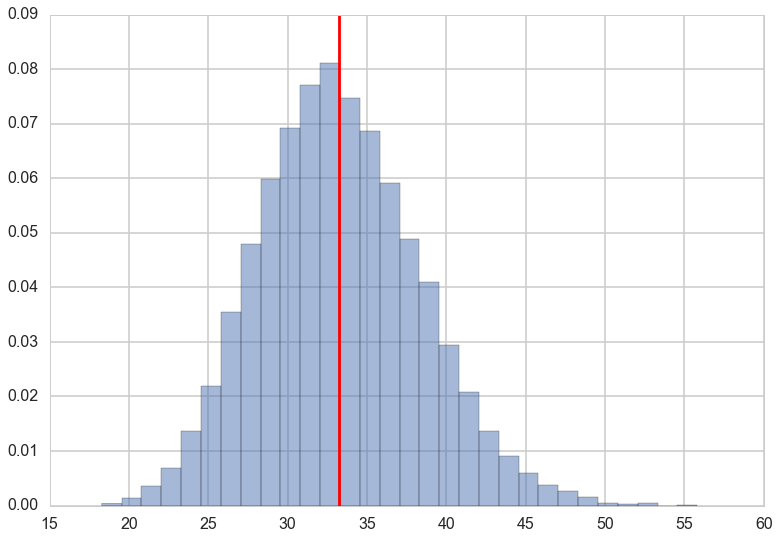

In [22]:
rv = expon(scale=1./lambda_from_mean)
M_samples=10000
N_points = timediffs.shape[0]
bs_p = rv.rvs(size=(M_samples, N_points))
sd_mean_p=np.mean(bs_p, axis=1)
sd_std_p=np.std(bs_p, axis=1)
plt.hist(sd_mean_p, bins=30, normed=True, alpha=0.5);
plt.axvline(timediffs.mean(), 0, 1, color='r', label='Our Sample')

Your turn to do the same for the poisson distribution, both the non-parametric and the parametric bootstrap.

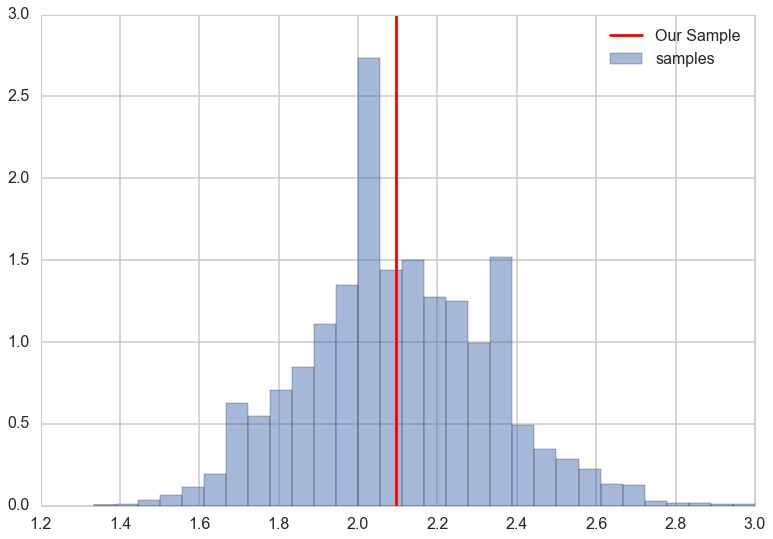

In [91]:
#your code here
M_samples=10000
N_points = poiskcount.shape[0]
bs_np = np.random.choice(poiskcount, size=(M_samples, N_points), replace=True)
sd_mean=np.mean(bs_np, axis=1)
sd_std=np.std(bs_np, axis=1)
plt.hist(sd_mean, bins=30, normed=True, alpha=0.5,label="samples");
plt.axvline(poiskcount.mean(), 0, 1, color='r', label='Our Sample')
plt.legend()

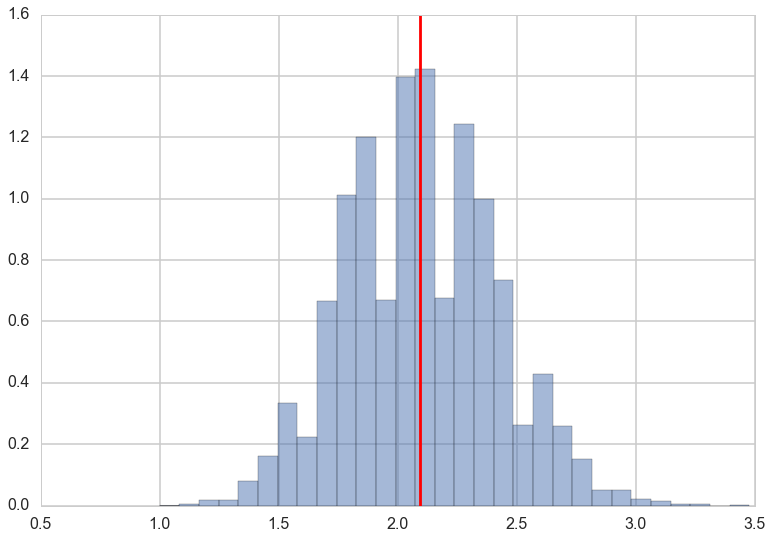

In [92]:
#your code here
rv = poisson(np.mean(poiskcount))
M_samples=10000
N_points = poiskcount.shape[0]
bs_p = rv.rvs(size=(M_samples, N_points))
sd_mean_p=np.mean(bs_p, axis=1)
sd_std_p=np.std(bs_p, axis=1)
plt.hist(sd_mean_p, bins=30, normed=True, alpha=0.5);
plt.axvline(poiskcount.mean(), 0, 1, color='r', label='Our Sample')